In [3]:
# Import the libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.shape, test.shape

((891, 12), (418, 11))

In [5]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [6]:
# Combined
combined = pd.concat([train, test], ignore_index = True)

combined.shape

(1309, 12)

In [7]:
# Missing Values

combined.isnull().sum()[combined.isnull().sum()!=0]

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [8]:
combined.loc[combined.Cabin.notnull(), "Pclass"].value_counts()

1    256
2     23
3     16
Name: Pclass, dtype: int64

In [9]:
# Bin the Cabins
cabins = combined.Cabin.unique()[1:]


def cab(x):
    if x in cabins:
        return("Cabin_Allotted")
    else:
        return("Missing")

In [10]:
combined["Cabin_Cat"] = combined.Cabin.apply(cab)

In [11]:
pd.get_dummies(combined, drop_first = True).shape

(1309, 2430)

<Axes: xlabel='Cabin_Cat'>

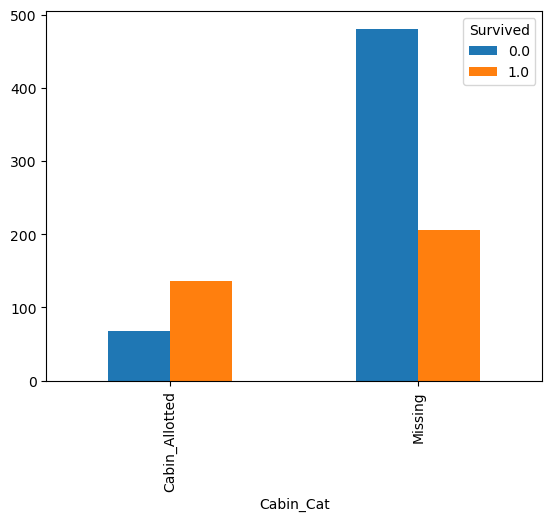

In [12]:
# Cabin vs Survived
tbl = pd.crosstab(combined.Cabin_Cat, combined.Survived)

tbl.plot(kind = "bar")

In [13]:
# Parch and Sibsp

combined["Family"] = combined.SibSp+combined.Parch+1

In [14]:
combined.Family.unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11], dtype=int64)

In [15]:
# 1 Singles, 2 couple 3 small family, >3: Large

def fam(x):
    if x ==1:
        return("Solo")
    elif x ==2:
        return("Couple")
    elif x==3:
        return("Small_Family")
    else:
        return("Large_Family")

In [16]:
combined["Family_Cat"] = combined.Family.apply(fam)

<Axes: xlabel='Family_Cat'>

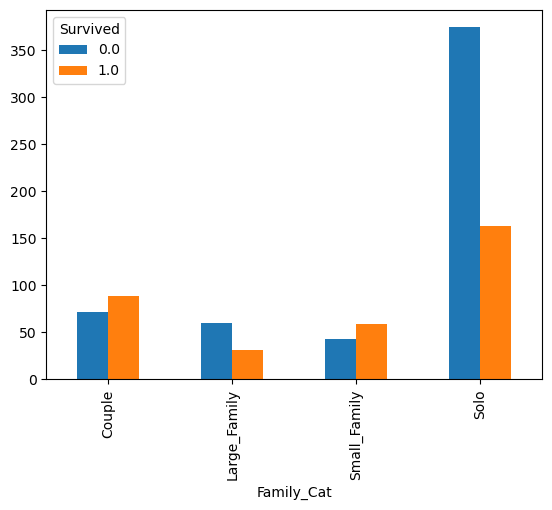

In [17]:
tbl = pd.crosstab(combined.Family_Cat, combined.Survived)

tbl.plot(kind = "bar")

In [18]:
combined.groupby("Sex")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,388.0,28.687088,14.576962,0.17,19.0,27.0,38.0,76.0
male,658.0,30.585228,14.280581,0.33,21.0,28.0,39.0,80.0


In [19]:
titles = []
for i in combined.Name:
    titles.append(i.split(",")[1].split(". ")[0].strip())

In [20]:
combined["titles"] = pd.Series(titles)

In [21]:
combined.titles.nunique()

18

In [22]:
ignore = ['Don', 'Rev', 'Dr', 'Mme',
       'Major', 'Lady', 'Sir', 'Mlle', 
          'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona']

def nahi_chahiye(x):
    if x in ignore:
        return("Others")
    else:
        return(x)

In [23]:
combined["titles"] = combined.titles.apply(nahi_chahiye)

In [24]:
combined.groupby("titles")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
titles,,,,,,,,
Master,53.0,5.482642,4.161554,0.33,2.0,4.0,9.0,14.5
Miss,210.0,21.774238,12.249077,0.17,15.0,22.0,30.0,63.0
Mr,581.0,32.252151,12.422089,11.00,23.0,29.0,39.0,80.0
Mrs,170.0,36.994118,12.901767,14.00,27.0,35.5,46.5,76.0
Ms,1.0,28.000000,NaN,28.00,28.0,28.0,28.0,28.0
Others,31.0,43.129032,12.309189,23.00,32.5,45.0,52.5,70.0


In [25]:
combined.loc[(combined.Age.isnull()) & 
             (combined.titles == "Master"), "Age"] = 4

combined.loc[(combined.Age.isnull()) & 
             (combined.titles == "Miss"), "Age"] = 22

combined.loc[(combined.Age.isnull()) & 
             (combined.titles == "Mr"), "Age"] = 29

combined.loc[(combined.Age.isnull()) & 
             (combined.titles == "Mrs"), "Age"] = 35.5

combined.loc[(combined.Age.isnull()) & 
             (combined.titles == "Ms"), "Age"] = 28

combined.loc[(combined.Age.isnull()) & 
             (combined.titles == "Others"), "Age"] = 45

In [26]:
combined.loc[combined.Fare.isnull(), 
             "Fare"] = combined.Fare.median()

In [27]:
# Embarked
combined.loc[combined.Embarked.isnull(), "Embarked"] = \
combined.Embarked.mode()[0]

In [28]:
# Drop the Unnecessary columns
combined.drop(["PassengerId", 
               "Parch", "SibSp", 
               "Name", "Cabin", "Ticket"], 
              axis = 1, inplace = True)

In [29]:
#combined.drop("Ticket", axis = 1, inplace = True)

In [30]:
#d.get_dummies(combined, drop_first = True)

# Split the Data in Train and Test


newtrain = combined.loc[0:train.shape[0]-1, :]
newtest = combined.loc[train.shape[0]:, :]

newtrain.shape, newtest.shape

((891, 10), (418, 10))

In [31]:
newtest.drop("Survived", axis = 1, inplace = True)

### Statistical Test

In [32]:
input_vars = ["Pclass", "Sex", "Embarked", 
              "Cabin_Cat", "Family_Cat", "titles"]

import scipy.stats as stats

# Ho: that the predictors and target are independent. It means
# Predictor Variables are not helping in predicting the Survival
# Ha: Ho is False

for i in input_vars:
    tbl = pd.crosstab(newtrain.loc[:, i], newtrain.Survived)
    teststats, pvalue, deg, exp_freq = stats.chi2_contingency(tbl)
    print(i, pvalue)


Pclass 4.549251711298793e-23
Sex 1.1973570627755645e-58
Embarked 2.3008626481449577e-06
Cabin_Cat 6.7419704360811776e-21
Family_Cat 4.6082741465220125e-11
titles 1.9783487591671835e-59


In [33]:
# Dummy

dummytrain = pd.get_dummies(newtrain, drop_first=True)
dummytest = pd.get_dummies(newtest, drop_first=True)

X = dummytrain.drop("Survived", axis = 1)

y = dummytrain.Survived

In [34]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

pred = logreg.fit(X, y).predict(dummytest)

In [35]:
# Submission

submission = pd.read_csv("~/Downloads/Titanic_Kaggle/gender_submission.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\hp/Downloads/Titanic_Kaggle/gender_submission.csv'

In [ ]:
submission["Survived"]= pred

submission["Survived"] = submission.Survived.astype(int)

In [ ]:
submission.to_csv("NayawalaLogreg_titanic.csv", index = False)

In [ ]:
submission.head()

In [ ]:
 from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
 

# Logistic Regression Model Using StatsModel

In [36]:
import statsmodels.api as sma
model=sma.Logit(y,X).fit()
model.summary()

         Current function value: 0.425795
         Iterations: 35


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      875
Method:                           MLE   Df Model:                           15
Date:                Thu, 29 Feb 2024   Pseudo R-squ.:                  0.3606
Time:                        13:20:07   Log-Likelihood:                -379.38
converged:                      False   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 9.405e-82
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Pclass                     -0.5159      0.179     -2.889      0.004      -0.866      -0.166
Age                        -0.0254      0.009     -2.716      0.007      -0.044      -0.007
Fare                        0.0058      0.003      2.038      0.042       0.000       0.011
Family                     -0.2792      0.181     -1.545      0.122      -0.634       0.075
Sex_male                    3.1430      0.646      4.867      0.000       1.877       4.409
Embarked_Q                 -0.1484      0.389     -0.382      0.702      -0.910       0.613
Embarked_S                 -0.2948      0.244     -1.210      0.226      -0.773       0.183
Cabin_Cat_Missing          -0.8933      0.315     -2.836      0.005      -1.511      -0.276
Family_Cat_Large_Family    -0.2141      0.715     -0.300      0.765      -1.615       1.187
Family_Cat_Small_Family     0.7003      0.389      1.799      0.072      -0.063       1.463
Family_Cat_Solo             0.3823      0.330      1.158      0.247      -0.265       1.030
titles_Miss                 3.7972      0.614      6.186      0.000       2.594       5.000
titles_Mr                  -2.1108      0.483     -4.370      0.000      -3.057      -1.164
titles_Mrs                  4.6859      0.691      6.783      0.000       3.332       6.040
titles_Ms                  24.2514   4.66e+04      0.001      1.000   -9.13e+04    9.13e+04
titles_Others              -0.6287      0.648     -0.969      0.332      -1.900       0.642
===========================================================================================
"""

In [37]:
X

,Pclass,Age,Fare,Family,Sex_male,Embarked_Q,Embarked_S,Cabin_Cat_Missing,Family_Cat_Large_Family,Family_Cat_Small_Family,Family_Cat_Solo,titles_Miss,titles_Mr,titles_Mrs,titles_Ms,titles_Others
0,3,22.0,7.2500,2,1,0,1,1,0,0,0,0,1,0,0,0
1,1,38.0,71.2833,2,0,0,0,0,0,0,0,0,0,1,0,0
2,3,26.0,7.9250,1,0,0,1,1,0,0,1,1,0,0,0,0
3,1,35.0,53.1000,2,0,0,1,0,0,0,0,0,0,1,0,0
4,3,35.0,8.0500,1,1,0,1,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,13.0000,1,1,0,1,1,0,0,1,0,0,0,0,1
887,1,19.0,30.0000,1,0,0,1,0,0,0,1,1,0,0,0,0
888,3,22.0,23.4500,4,0,0,1,1,1,0,0,1,0,0,0,0
889,1,26.0,30.0000,1,1,0,0,0,0,0,1,0,1,0,0,0


In [38]:
#Family_Cat_Large_Family,Family
newx=X.drop(['Family_Cat_Large_Family','Family','Embarked_Q','titles_Ms','titles_Others','Fare'],axis=1)
model=sma.Logit(y,newx).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.438260
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      881
Method:                           MLE   Df Model:                            9
Date:                Thu, 29 Feb 2024   Pseudo R-squ.:                  0.3419
Time:                        13:20:11   Log-Likelihood:                -390.49
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 8.426e-82
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Pclass                     -0.7247      0.156     -4.639      0.000      -1.031      -0.419
Age                        -0.0268      0.008     -3.348      0.001      -0.043      -0.011
Sex_male                    2.4993      0.481      5.200      0.000       1.557       3.441
Embarked_S                 -0.4054      0.198     -2.050      0.040      -0.793      -0.018
Cabin_Cat_Missing          -0.9539      0.302     -3.160      0.002      -1.545      -0.362
Family_Cat_Small_Family     0.9162      0.309      2.964      0.003       0.310       1.522
Family_Cat_Solo             0.9286      0.239      3.890      0.000       0.461       1.397
titles_Miss                 3.6134      0.447      8.076      0.000       2.736       4.490
titles_Mr                  -1.5082      0.341     -4.429      0.000      -2.176      -0.841
titles_Mrs                  4.6001      0.552      8.339      0.000       3.519       5.681
===========================================================================================
"""

In [39]:
#Logistic Regression Equation
Logit=model.params[0]*dummytest.Pclass+model.params[1]*newtest.Age+\
model.params[2]*dummytest.Sex_male+\
model.params[3]*dummytest.Embarked_S+\
model.params[4]*dummytest.Cabin_Cat_Missing+\
model.params[5]*dummytest.Family_Cat_Small_Family+\
model.params[6]*dummytest.Family_Cat_Solo+\
model.params[7]*dummytest.titles_Miss+\
model.params[8]*dummytest.titles_Mr+\
model.params[9]*dummytest.titles_Mrs

In [40]:
deno=1+np.exp(-Logit)
prob=1/deno
#print(prob)

def zero_one(x):
    if x<0.5:
        return(0)
    else:
        return(1)

In [41]:
prob.apply(zero_one)

891     0
892     0
893     0
894     0
895     1
       ..
1304    0
1305    0
1306    0
1307    0
1308    1
Length: 418, dtype: int64

# Pseudo R squared
* Mcfadden R2** This R2 is not what we have understood in Linear Regression.
* In Linear Regression , R2 will explain the variance in y because of X.
* However , in logistic Regression, R2 is called Pseudo R2 because here the R2 of LOg Reg model cannnot explain the varinace in the target 
 * because of the X .

* R2 in Log model can approach 1 however , in relaity it is practically not possible.

* in case of mcfadden, the range is between 0.2-0.4.
**Cox and Snell**
* Cox and Snell's R2 is generally more focused on nested logistic
  Regression Models. It means that if in add a new predictor into the model and this r2 increases, then i can say that the new predictor is a significant predictor for the target 
  **Nagelkerke**
  * Nagelkerke has a very high r2 value and it is the goto metric for understanding the model's predictive power.
  
  * Pseudo R2 tells us about the predictive power of the model.In other words, it explains how well our model is able to predict    the Binary Outcome(target variable)

In [42]:
#McFadden=1-llf/llnull
mcfadden=1-(model.llf/model.llnull)
print('Mcfadden',mcfadden)

Mcfadden 0.341864596470002


In [43]:
# Cox and Snell
L1=np.exp(model.llf)
L0=np.exp(model.llnull)
#mcfadden**(2/newx.shape[0])
cox_snell=1-(L0/L1)**(2/newx.shape[0])
cox_snell

0.3657445300620269

In [44]:
#Nagelkerke
nagelkerke=cox_snell/(1-(L0)**(2/newx.shape[0]))
print(nagelkerke)

0.4969323351293346


Gaussian Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
pred=gnb.fit(X,y).predict(dummytest)
pred

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 1.